In [ ]:
# This notebook tests the making of pre-made masks for the Fizeau PSF FFT

# created 2018 July 16 by E.S.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata.utils import extract_array
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion
from pyregion import read_region_as_imagecoord, get_mask
% matplotlib inline

In [2]:
from lmircam_tools import *
from lmircam_tools import overlap_psfs

In [3]:
# for starters, read in some real data and FFT the Fizeau/Airy PSFs

In [4]:
stem = ('/home/../../media/unasemaje/Seagate Expansion Drive/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/')

In [5]:
# set units of the observation

wavel_lambda = 3.7e-6 # meters
D = 8.25 # meters
B_c2c = 14.4 # meters
B_e2e = 22.65 # meters
plateScale = 0.0107 # asec/pixel
global asecInRad
asecInRad = 206264.81

In [6]:
# locations of Airy minima/maxima (units lambda/D)

max1 = 0
min1 = 1.220
max2 = 1.635
min2 = 2.233
max3 = 2.679
min3 = 3.238
max4 = 3.699

In [7]:
# put in init

def findFFTloc(baseline,imageShapeAlong1Axis,wavel_lambda,plateScale,lOverD=1.):
    # returns the FFT pixel locations equivalent to a certain pixel distance on the science image 
    
    # baseline: distance in physical space in the pupil plane (in m)
    # imageShapeAlong1Axis: length of one side of the input image (needs to be square)
    # wavel_lambda: wavelength of light (in m)
    # plateScale: detector plate scale (in asec/pix)
    # lOverD: option if we are interested in the circular Airy rings (values 1.22, etc.)
    
    line_diam_pixOnScience = lOverD*(wavel_lambda*asecInRad)/(baseline*plateScale) # distance in pixels on science detector
    line_diam_freq = np.divide(1.,line_diam_pixOnScience) # the corresponding frequency
    line_diam_pixOnFFT_L = 0.5*imageShapeAlong1Axis - np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    line_diam_pixOnFFT_H = 0.5*imageShapeAlong1Axis + np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    
    return line_diam_pixOnFFT_L, line_diam_pixOnFFT_H # the lower and higher values around freq of zero

In [37]:
def normalVector(sciImg):
    ## fit a plane by finding the (normalized) normal vector to the best-fit plane
    
    # make x, y coords and flatten x, y, and z for putting into least-squares matrix equation
    X,Y = np.meshgrid(np.arange(0,np.shape(sciImg)[0]),
                  np.arange(0,np.shape(sciImg)[1]))
    print(np.shape(sciImg))
    Xflat_T = np.transpose(X.flatten())
    Yflat_T = np.transpose(Y.flatten())
    onesVec = np.ones(np.size(Xflat_T))
    Zflat_T = np.transpose(sciImg.flatten())
    #Zflat_T = np.transpose(np.flipud(sciImg).flatten()) # flipping up-down to avoid some weirdness that happens in the later dot product

    # remove nans so we can fit planes
    Xflat_T = Xflat_T[~np.isnan(Zflat_T)]
    Yflat_T = Yflat_T[~np.isnan(Zflat_T)]
    onesVec = onesVec[~np.isnan(Zflat_T)]
    Zflat_T = Zflat_T[~np.isnan(Zflat_T)]
    
    # For a plane ax+by+c=z, the normal vector is [a,b,c]. To find this,
    # solve the matrix equation 
    
    # AC = B, where 
    # A are the x and y coords: [[x0,y0,1],[x1,y1,1],...[xN,yN,1]]
    # C are the coefficients we want: [[a],[b],[c]]
    # B is the z data: [[z0],[z1],...[zN]]
    
    # C = A+B, where A+ is the pseudoinverse of A, or A+ = ((A.T*A)^(-1))*A.T*B
    
    Amatrix = np.transpose(np.concatenate(([Xflat_T],[Yflat_T],[onesVec]), axis =0))
    Bmatrix = Zflat_T
    
    # note normVec_unnorm = C
    normVec_unnorm = np.dot(np.dot( np.linalg.pinv(np.dot(Amatrix.transpose(), Amatrix)), Amatrix.transpose()), Bmatrix)
    normVec = np.divide(normVec_unnorm, np.linalg.norm(normVec_unnorm)) # normalize

    return normVec_unnorm

In [50]:
def fftMask(sciImg,wavel_lambda,plateScale):
    # sciImg: this is actually the FFT image, not the science detector image
    # wavel_lambda: wavelenth of the observation
    # plateScale: plate scale of the detector (asec/pixel)
    
    # make division lines separating different parts of the PSF
    line_M1diam_pixOnFFT = findFFTloc(8.25,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_center2center_pixOnFFT = findFFTloc(14.4,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_edge2edge_pixOnFFT = findFFTloc(22.65,np.shape(sciImg)[0],wavel_lambda,plateScale) 
        
    # define circles
    circRad = 100 # pixels in FFT space
    circle_highFreqPerfect_L = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[0], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_highFreqPerfect_R = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_lowFreqPerfect = CirclePixelRegion(center=PixCoord(x=0.5*np.shape(sciImg)[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    
    # define central rectangular region that includes all three nodes
    rect_pix = PolygonPixelRegion(vertices=PixCoord(x=[line_edge2edge_pixOnFFT[0],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[0]], 
                                                       y=[line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[0],line_M1diam_pixOnFFT[0]]))
    
    # make the masks 
    mask_circHighFreq_L = circle_highFreqPerfect_L.to_mask()
    mask_circHighFreq_R = circle_highFreqPerfect_R.to_mask()
    mask_circLowFreq = circle_lowFreqPerfect.to_mask()
    mask_rect = rect_pix.to_mask()

    # apply the masks
    sciImg1 = np.copy(sciImg)
    sciImg2 = np.copy(sciImg)
    sciImg3 = np.copy(sciImg)
    sciImg4 = np.copy(sciImg)
    
    # region 1
    sciImg1.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_L.data[mask_circHighFreq_L.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg1[mask_circHighFreq_L.bbox.slices] = mask_circHighFreq_L.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg1 = np.multiply(sciImg1,sciImg) # 'transmit' the original science image through the mask

    # region 2
    sciImg2.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_R.data[mask_circHighFreq_R.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg2[mask_circHighFreq_R.bbox.slices] = mask_circHighFreq_R.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg2 = np.multiply(sciImg2,sciImg) # 'transmit' the original science image through the mask

    # region 3
    sciImg3.fill(np.nan) # initialize arrays of nans
    mask_circLowFreq.data[mask_circLowFreq.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg3[mask_circLowFreq.bbox.slices] = mask_circLowFreq.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg3 = np.multiply(sciImg3,sciImg) # 'transmit' the original science image through the mask

    # region 4
    sciImg4.fill(np.nan) # initialize arrays of nans
    mask_rect.data[mask_rect.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg4[mask_rect.bbox.slices] = mask_rect.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg4 = np.multiply(sciImg4,sciImg) # 'transmit' the original science image through the mask

    plt.imshow(sciImg1, origin='lower')
    plt.show()
    
    plt.imshow(sciImg2, origin='lower')
    plt.show()
    
    plt.imshow(sciImg3, origin='lower')
    plt.show()
    
    plt.imshow(sciImg4, origin='lower')
    plt.show()
    
    # return bits of the image that are masked, their medians, 
    # their x- and y-slopes, and an image indicating the regions
    med_highFreqPerfect_L = np.nanmedian(sciImg1)
    med_highFreqPerfect_R = np.nanmedian(sciImg2)
    med_lowFreqPerfect = np.nanmedian(sciImg3)
    med_rect = np.nanmedian(sciImg4)
    
    # return normal vectors to surfaces
    ## ##normVec_highFreqPerfect_L = normalVector(sciImg1[mask_circHighFreq_L.bbox.slices])
    #sciImg1[mask_circHighFreq_L.bbox.slices[0][0]:mask_circHighFreq_L.bbox.slices[1]] = np.nan
    #plt.imshow(sciImg1)
    #plt.show()
    #print(mask_circHighFreq_L.bbox.slices.indices())
    #normVec_highFreqPerfect_L = normalVector(sciImg1[mask_circHighFreq_L.bbox.slices])
    normVec_highFreqPerfect_L = normalVector(sciImg1)
    normVec_highFreqPerfect_R = normalVector(sciImg2)
    normVec_lowFreqPerfect = normalVector(sciImg3)
    normVec_rect = normalVector(sciImg4)
        
    # generate an image showing footprints of regions of interest
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.imshow(sciImg, origin="lower")
    ax.axhline(line_M1diam_pixOnFFT[0])
    ax.axhline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_M1diam_pixOnFFT[0])
    ax.axvline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_center2center_pixOnFFT[0])
    ax.axvline(line_center2center_pixOnFFT[1])
    ax.axvline(line_edge2edge_pixOnFFT[0]) 
    ax.axvline(line_edge2edge_pixOnFFT[1]) 
    ax.add_patch(circle_highFreqPerfect_L.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_highFreqPerfect_R.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_lowFreqPerfect.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(rect_pix.as_patch(facecolor='none', edgecolor='red')) 
    cbar = fig.colorbar(cax)
    plt.savefig("junk.pdf")
        
    dictFFTstuff = {}
    dictFFTstuff["med_highFreqPerfect_L"] = med_highFreqPerfect_L
    dictFFTstuff["med_highFreqPerfect_R"] = med_highFreqPerfect_R
    dictFFTstuff["med_lowFreqPerfect"] = med_lowFreqPerfect
    dictFFTstuff["med_rect"] = med_rect
    dictFFTstuff["normVec_highFreqPerfect_L"] = normVec_highFreqPerfect_L
    dictFFTstuff["normVec_highFreqPerfect_R"] = normVec_highFreqPerfect_R
    dictFFTstuff["normVec_lowFreqPerfect"] = normVec_lowFreqPerfect
    dictFFTstuff["normVec_rect"] = normVec_rect
    #dictFFTstuff["global"] = ax
    
    return dictFFTstuff
    
    

In [51]:
# make test data

row, col = np.indices((1024,1024))
image = np.ones((2048,2048), dtype=np.float64)
psf_loc = [1024, 1024]
#amp = np.ones((1024,1024), dtype=np.float64)*3
#amp[:,0:512] = -3
amp = row.astype(np.float64)
amp -= np.median(amp)
amp[:,:264] = np.nan
amp[:,350:] = np.nan
#arg = np.ones((1024,1024), dtype=np.float64)*4
#arg[:,0:512] = -2
arg = col.astype(np.float64)
arg -= np.median(arg)
arg = 2000*arg

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
a = 2.1
b = -1.4
c = 5.2
X, Y = np.meshgrid(np.arange(1024),np.arange(1024))
Z = a*X + b*Y + c

In [53]:
amp = Z
image = Z

Working on frame 008608 ...


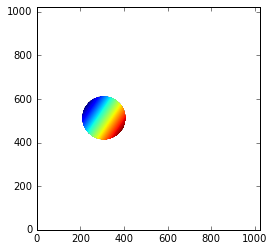

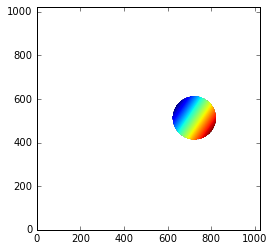

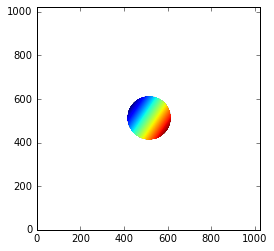

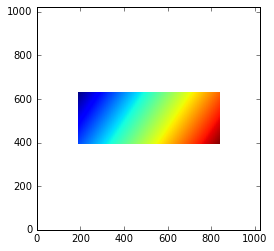

(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
{'med_lowFreqPerfect': 363.60000000000008, 'normVec_lowFreqPerfect': array([ 2.1, -1.4,  5.2]), 'med_rect': 363.60000000000008, 'med_highFreqPerfect_R': 797.60000000000014, 'normVec_highFreqPerfect_L': array([ 2.1, -1.4,  5.2]), 'normVec_highFreqPerfect_R': array([ 2.1, -1.4,  5.2]), 'normVec_rect': array([ 2.1, -1.4,  5.2]), 'med_highFreqPerfect_L': -70.399999999999906}


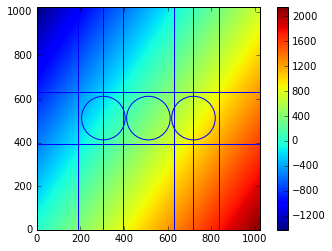

In [54]:
# beta ver

ampArray = []
framenumArray = []
for f in range(8608,8609):  # 9510

    filename_str = stem+'lm_180507_'+str("{:0>6d}".format(f))+'.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
    
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        ## ## image, header = fits.getdata(filename_str,0,header=True) 
        
        # a perfect PSF
        #image, header = fits.getdata(stem+'perfect_psf.fits',0,header=True) 
    
        # locate PSF
        psf_loc = overlap_psfs.find_airy_psf(image)
        #print(psf_loc)
    
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 100 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT
        cookie_cut = image[psf_loc[0]-cookie_size:psf_loc[0]+cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        ## ## amp, arg = fft_img(cookie_cut).fft(padding=int(5*cookie_size), mask_thresh=1e5)
    
        #print(np.shape(cookie_cut))
    
        #plt.imshow(cookie_cut)
        #plt.show()
    
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
        fftInfo_amp = fftMask(amp,wavel_lambda,plateScale)
        print(fftInfo_amp)
        #fftInfo_arg = fftMask(arg,wavel_lambda,plateScale)
        #print(fftInfo_arg)

            
        plt.show()
        
        #highFreqNode = amp[line_M1diam_pixOnFFT[0]:line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1]:line_edge2edge_pixOnFFT[1]]
        
        #ampArray = np.concatenate((ampArray, [np.median(highFreqNode)]))
        #framenumArray = np.concatenate((framenumArray, [f]))
        
        #plt.clf()
        #plt.imshow(highFreqNode)
        
        
        
        
    
        #plt.savefig("images/psf_altair_fft_check_"+str("{:0>6d}".format(f))+".png", dpi=300, overwrite=False)
        #plt.savefig("images/test.pdf", dpi=300, overwrite=True)
        #plt.clf()

In [28]:
# for loop to take cookie cut-outs of Fizeau/Airy PSFs, and take FFTs

ampArray = []
framenumArray = []
for f in range(7608,7609):  # 9510

    filename_str = stem+'lm_180507_'+str("{:0>6d}".format(f))+'.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
    
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        image, header = fits.getdata(filename_str,0,header=True) 
        
        # a perfect PSF
        #image, header = fits.getdata(stem+'perfect_psf.fits',0,header=True) 
    
        # locate PSF
        psf_loc = overlap_psfs.find_airy_psf(image)
        #print(psf_loc)
    
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 100 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT
        cookie_cut = image[psf_loc[0]-cookie_size:psf_loc[0]+cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        amp, arg = fft_img(cookie_cut).fft(padding=int(5*cookie_size), mask_thresh=1e5)
    
        #print(np.shape(cookie_cut))
    
        #plt.imshow(cookie_cut)
        #plt.show()
    
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
        # make division lines separating different parts of the PSF
        line_M1diam_pixOnFFT = findFFTloc(8.25,np.shape(amp)[0],wavel_lambda,plateScale)
        line_center2center_pixOnFFT = findFFTloc(14.4,np.shape(amp)[0],wavel_lambda,plateScale)
        line_edge2edge_pixOnFFT = findFFTloc(22.65,np.shape(amp)[0],wavel_lambda,plateScale)    
    
        # make the actual masks
        highFreqPerfect_R = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[1], y=0.5*np.shape(amp)[0]), radius=50)
        circle = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[1], y=0.5*np.shape(amp)[0]), radius=100)
        mask = circle.to_mask()
        mask2 = highFreqPerfect_R.to_mask()
        mask.data[mask.data == 0] = np.nan    # make zeros within mask square nans
        arg[mask.bbox.slices] *= mask.data
        print(np.median(arg[mask.bbox.slices]))
        
        #arg[~mask] *= np.nan
        
        #print(type(mask2))
        #print(mask2)
        #cutout = ma.masked_array(arg, mask=mask2.data)
        #arg[mask2.bbox.slices] = np.nan
        #cutout = arg[~arg.mask]  #cutout(arg) * mask.data
        #plt.imshow(arg)
        #ax = fig.add_subplot(1, 1, 1)
        #ax.add_patch(circle.as_patch(facecolor='none', edgecolor='blue'))
        #plt.imshow(mask.data)
        #plt.show()
    
        #plt.imshow(cookie_cut, origin='lower')
        #plt.show()
            
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(arg, origin="lower")
        ax.axhline(line_M1diam_pixOnFFT[0])
        ax.axhline(line_M1diam_pixOnFFT[1])
        ax.axvline(line_M1diam_pixOnFFT[0])
        ax.axvline(line_M1diam_pixOnFFT[1])
        ax.axvline(line_center2center_pixOnFFT[0])
        ax.axvline(line_center2center_pixOnFFT[1])
        ax.axvline(line_edge2edge_pixOnFFT[0]) 
        ax.axvline(line_edge2edge_pixOnFFT[1]) 
        ax.add_patch(circle.as_patch(facecolor='none', edgecolor='blue')) 
        plt.show()
        
        #highFreqNode = amp[line_M1diam_pixOnFFT[0]:line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1]:line_edge2edge_pixOnFFT[1]]
        
        ampArray = np.concatenate((ampArray, [np.median(highFreqNode)]))
        framenumArray = np.concatenate((framenumArray, [f]))
        
        #plt.clf()
        #plt.imshow(highFreqNode)
        
        
        
        
    
        #plt.savefig("images/psf_altair_fft_check_"+str("{:0>6d}".format(f))+".png", dpi=300, overwrite=False)
        #plt.savefig("images/test.pdf", dpi=300, overwrite=True)
        #plt.clf()

Working on frame 007608 ...
129.449968559


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from regions import CirclePixelRegion, PixCoord
center=PixCoord(10,10)
circle=CirclePixelRegion(center, 5)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
np.random.seed(12345)
data=np.random.random((20,20))
mask=circle.to_mask()
data[mask.bbox.slices] *= 1 - mask.data
ax.imshow(data, interpolation='nearest', cmap='viridis')
ax.add_patch(circle.as_patch(facecolor='none', edgecolor='red'))
plt.show()

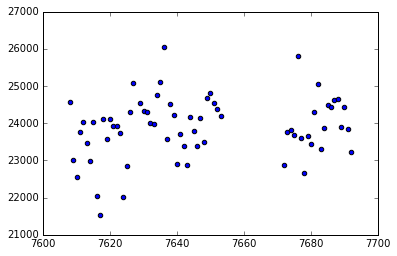

In [13]:
plt.scatter(framenumArray,ampArray)
plt.show()

In [ ]:
# how are FFTs affected by
# 1. fringe movement
# 2. changing visibility
# 3. stuff listed in my table

# ... and how good am I at finding the center of the PSF?

In [ ]:
# based on the images, decide whether to move HPC in piston, tip, tilt
# iterate?
# maybe I don't want to move HPC in piston, because I found the center of the envelope with the grism,
# and Phasecam isn't closed yet